In [1]:
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import scipy.stats as ss
from pathlib import Path
import dill
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

util_path = '/sdcc/u/yhuang2/PROJs/EICLDRD/utils'
assert Path(util_path).exists()
if util_path not in sys.path:
    sys.path.append(util_path)

# printing with style
from text_style import text_style
ts = text_style()
# a simple stdout logger
from dev_log import dev_log
logger = dev_log()
# dataloading apparatus
from network_design import network_design
from visualize import plot_losses, plot_histograms, plot_histogram_2d, plot_errors, visualize_2d, visualize_3d

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
torch.cuda.is_available()

True

## Load data

In [5]:
class dataset_toyzero(torch.utils.data.Dataset):
    """
    LS4GAN dataset
    """
    def __init__(
        self, 
        paths, *,
        clip=None,
        batch_size=1, 
        valid_fraction=.2,
        max_num=None,
    ):
        super(dataset_toyzero, self).__init__()    
        
        self.clip = clip
        
        self.image_fnames = []
        for path in paths:
            self.image_fnames += list(Path(path).glob('*npz'))
        self.image_fnames = np.array(self.image_fnames)
        
        indices = np.arange(len(self.image_fnames))
        np.random.shuffle(indices)
        if max_num is not None:
            indices = indices[:max_num]
        valid_size = int(len(indices) * valid_fraction)
        train_size = len(indices) - valid_size
        indices_train = indices[:train_size]
        indices_valid = indices[train_size:]
        print(f'train example: {train_size} / {len(indices)}')
        print(f'valid example: {valid_size} / {len(indices)}')

        self.data_loaders = {}
        for split, I in zip(['train', 'valid'], [indices_train, indices_valid]):
            datum = np.array(list(map(self._load_file, self.image_fnames[I])))
            loader = torch.utils.data.DataLoader(datum, batch_size=bsz, shuffle=True)
            self.data_loaders[split] = loader
    
    def _load_file(self, fname):
        datum = np.load(fname)
        datum = datum[datum.files[0]]
        if self.clip is not None:
            datum = datum[:self.clip[0], :self.clip[1]]
        mode = ss.mode(datum, axis=None)[0][0]
        datum -= mode
        return np.expand_dims(np.float32(datum), 0)
    
    def get_split(self, split):
        return self.data_loaders[split]

    def get_splits(self):
        return self.data_loaders['train'], self.data_loaders['valid']

In [7]:
bsz = 20
paths = [
    Path(f'/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_2021-06-29_safi_U/trainA/'),
    Path(f'/sdcc/u/yhuang2/PROJs/GAN/datasets/ls4gan/toyzero_cropped/toyzero_2021-06-29_safi_U/trainB/')
]


ds = dataset_toyzero(paths, clip=[128, 128], batch_size=bsz, valid_fraction=.4, max_num=2000)
train_loader, valid_loader = ds.get_splits()
print(f'Number of batches:\
    \n\ttrain = {len(train_loader)}\
    \n\tvalidation = {len(valid_loader)}')

train example: 1200 / 2000
valid example: 800 / 2000
Number of batches:    
	train = 60    
	validation = 40


## Model Architecture
Parameters Design and Trail Run

In [8]:
%load_ext autoreload
%autoreload 2

# Load model
model_path = '/sdcc/u/yhuang2/PROJs/GAN/collisionGAN/models'
assert Path(model_path).exists()
if model_path not in sys.path:
    sys.path.append(model_path)
from CNNAE import CNNAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
path_prefix = 'results/2021-07-20_14-12_cropped_twoheaded_4/'
model_state_dict = torch.load(f'{path_prefix}/epoch-199.pt')

In [12]:
def trial(model, input_shape, cuda=True, single=False):
    x = torch.rand(1, 1, *input_shape, dtype=torch.float32)
    if cuda:
        model = model.cuda()
        x = x.cuda()

    logger.switch_debug(True)
    if single:
        y = model.forward(x)
    else:
        y_c, y_r = model.forward(x)
    logger.switch_debug(False)
    print(y_c.shape)
    print(y_r.shape)

    num_parameters_trainable = sum([p.numel() for p in model.parameters() if p.requires_grad])
    num_parameters = sum([p.numel() for p in model.parameters()])
    print(f'{ts.OKCYAN}Number of parameters:\n\tTrainable = {num_parameters_trainable}\n\tTotal = {num_parameters}{ts.ENDC}') 

In [13]:
csz = [64, 128, 256, 256]
oneOneConvCsz = 8
rcsz = [8, 8, 4, 2]

#input_shape = [800, 6000]
input_shape = [128, 128]

filters = [[3, 3], [3, 3], [3, 3], [3, 3]]
strides = [[2, 2], [2, 2], [2, 2], [2, 2]]

output_paddings = network_design().get_output_padding(input_shape, filters, strides)

# Model initialization and trial
model = CNNAE(
    csz, rcsz, 
    filters, strides, output_paddings, 
    evaluation_mode=False, 
    oneOneConvCsz=oneOneConvCsz, 
    residual=True,
    single=False,
    linear=True
)
# model.load_state_dict(model_state_dict)
trial(model, input_shape, single=False)

2021-07-22 15:30:57:DEBUG:output shape = torch.Size([1, 8, 8, 8])

2021-07-22 15:30:57:DEBUG:compression ratio =  32.000


layer 1:
	[128 128] -> [64 64]                
	[127 127], output_padding=[1, 1]

layer 2:
	[64 64] -> [32 32]                
	[63 63], output_padding=[1, 1]

layer 3:
	[32 32] -> [16 16]                
	[31 31], output_padding=[1, 1]

layer 4:
	[16 16] -> [8 8]                
	[15 15], output_padding=[1, 1]

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
Number of parameters:
	Trainable = 3291594
	Total = 3291594


## Train Parameters

In [14]:
model = CNNAE(
    csz, rcsz, 
    filters, strides, output_paddings, 
    evaluation_mode=False, 
    oneOneConvCsz=oneOneConvCsz, 
    residual=True,
    single=False,
    linear=True,
).cuda()

lr_initial, ratio_initial = 0.001, 20
ratio, epochs = ratio_initial, 200

optimizer = torch.optim.AdamW(model.parameters(), lr=lr_initial)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=5)

def get_lr(epoch, lr, rate=.95, every_num_epochs=20, minimum_lr=0.00001):
    lr = lr * (rate ** (epoch // every_num_epochs))
    if lr < minimum_lr:
        lr = minimum_lr
    return lr


def loss_regression(input_regression, input_classification, target, weight_pow=0.5, threshold=.5):
    input_combined = input_regression * (input_classification > threshold)
    # weight = torch.pow(torch.abs(target), weight_pow)
    # return torch.sum(torch.square(input_combined - target) * weight) / torch.sum(weight)
    # return torch.mean(torch.square(input_combined - target))
    return torch.mean(torch.abs(input_combined - target))

    
class SigmoidStep(nn.Module):
    """
    SigmoidStep can also be used to implement a soft-classfication. 
    """
    def __init__(self, mu, alpha):
        super(SigmoidStep, self).__init__()
        self.mu, self.alpha = mu, alpha

    def forward(self, x):
        y = self.alpha * (x - self.mu)
        return torch.sigmoid(y)

    
def loss_classification(input_classification, target, gamma=2, eps=1e-8):
    step = SigmoidStep(.5, 20)
    soft_label_target = step(torch.abs(target))
    I = input_classification
    J = 1 - input_classification
    I, J = I + eps, J + eps
    
    focal_loss = soft_label_target * torch.log2(I) * torch.pow(J, gamma) + (1 - soft_label_target) * torch.log2(J) * torch.pow(I, gamma)    
    return -torch.mean(focal_loss)

## Training

In [65]:
# We are going to use a timestamp for identifying saved run results.
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
brief_description = f'cropped_twoheaded_cr-64'
run_name = current_time + '_' + brief_description
print(f'Run name: {run_name}')
path_prefix = f'/sdcc/u/yhuang2/PROJs/GAN/collisionGAN/compression/results/{run_name}/'
Path(path_prefix).mkdir()

Run name: 2021-07-20_15-44_cropped_twoheaded_cr-64


In [ ]:
metric = nn.MSELoss()
train_losses, valid_losses = [], []
MSEs = []
for e in range(epochs):
    # Adjust learning rate
#     lr = get_lr(e, lr_initial)
#     for g in optimizer.param_groups:
#         g['lr'] = lr
    
    # training
    for x in train_loader:
        x = x.cuda()
        y_c, y_r = model(x)
        loss_c = loss_classification(y_c, x)
        loss_r = loss_regression(y_r, y_c, x)
        loss = loss_r +  ratio * loss_c
        train_losses.append([loss_c.item(), loss_r.item(), loss.item()])
        
        # back-propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # validation
    for x in valid_loader:
        x = x.cuda()
        y_c, y_r = model(x)        
        val_loss_c = loss_classification(y_c, x)
        val_loss_r = loss_regression(y_r, y_c, x)
        val_loss = val_loss_r +  ratio * val_loss_c
        
        m = metric(y_r * (y_c > .5), x)
        MSEs.append(m.item())
        valid_losses.append([val_loss_c.item(), val_loss_r.item(), val_loss.item()])

    train_loss_avg = np.mean(train_losses[-len(train_loader):], axis=0)
    valid_loss_avg = np.mean(valid_losses[-len(valid_loader):], axis=0)
    mse_avg = np.mean(MSEs[-len(valid_loader):])
    
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        break
    
    print(f'Epoch {e}: {lr: .6f}, {ratio:.6f}')
    print(f'\ttrain loss = {train_loss_avg[0]: .6f}, {train_loss_avg[1]: .6f}, {train_loss_avg[2]: .6f}')
    print(f'\tvalid loss = {valid_loss_avg[0]: .6f}, {valid_loss_avg[1]: .6f}, {valid_loss_avg[2]: .6f}, {mse_avg: .6f}\n')
    
    ratio = train_loss_avg[1] / train_loss_avg[0]
    scheduler.step(val_loss)
    if e % 20 == 19:
        torch.save(model.state_dict(), f'{path_prefix}/epoch-{e}.pt')

## Peak memory use

In [67]:
memory_all = torch.cuda.max_memory_allocated(device=None)
memory_cuda = torch.cuda.max_memory_allocated(device='cuda')
print(memory_all/1024 ** 3)
print(memory_cuda/1024 ** 3)

1.7458992004394531
1.7458992004394531


## Evaluation

In [68]:
model_state_dict = model.state_dict()

In [15]:
model = CNNAE(
    csz, rcsz, 
    filters, strides, output_paddings, 
    evaluation_mode=False, 
    oneOneConvCsz=oneOneConvCsz, 
    residual=True,
    single=False,
    linear=True
).cuda()
model.load_state_dict(model_state_dict)
model.eval()

test_losses_float32 = []
for x in valid_loader:
    x = x.cuda()
    y_c, y_r = model(x)
    loss_c = loss_classification(y_c, x)
    loss_r = loss_regression(y_r, y_c, x)
    
    test_losses_float32.append([loss_c.item(), loss_r.item()])

tl_mean_float32, tl_std_float32 = np.mean(test_losses_float32, axis=0), np.std(test_losses_float32, axis=0)
print(f'Test loss with float32:')
print(f'\tmean = {tl_mean_float32[0]:.6f}, {tl_mean_float32[1]:.6f}')
print(f'\tstd = {tl_std_float32[0]:.6f}, {tl_std_float32[1]:.6f}')

Test loss with float32:
	mean = 0.009755, 0.067150
	std = 0.002727, 0.007453


### Evaluation with low-precision (float16) data

In [16]:
model = CNNAE(
    csz, rcsz, 
    filters, strides, output_paddings, 
    evaluation_mode=True, 
    oneOneConvCsz=oneOneConvCsz, 
    residual=True,
    single=False,
    linear=True
).cuda()
model.load_state_dict(model_state_dict)
model.eval()

test_losses_float16 = []
for x in valid_loader:
    x = x.cuda()
    y_c, y_r = model(x)
    y_c, y_r = y_c.type(torch.float32), y_r.type(torch.float32)
    # Guarding values too close to 0 or 1 for the logarithmics
    y_c[y_c == 0] = 1e-6
    y_c[y_c == 1] = 1 - 1e-6
    
    loss_c = loss_classification(y_c, x)
    loss_r = loss_regression(y_r, y_c, x)
    
    test_losses_float16.append([loss_c.item(), loss_r.item()])

tl_mean_float16, tl_std_float16 = np.mean(test_losses_float16, axis=0), np.std(test_losses_float16, axis=0)
print(f'Test loss with float16:')
print(f'\tmean = {tl_mean_float16[0]:.6f}, {tl_mean_float16[1]:.6f}')
print(f'\tstd = {tl_std_float16[0]:.6f}, {tl_std_float16[1]:.6f}')

Test loss with float16:
	mean = 0.009542, 0.067135
	std = 0.002387, 0.009882


## Visualize

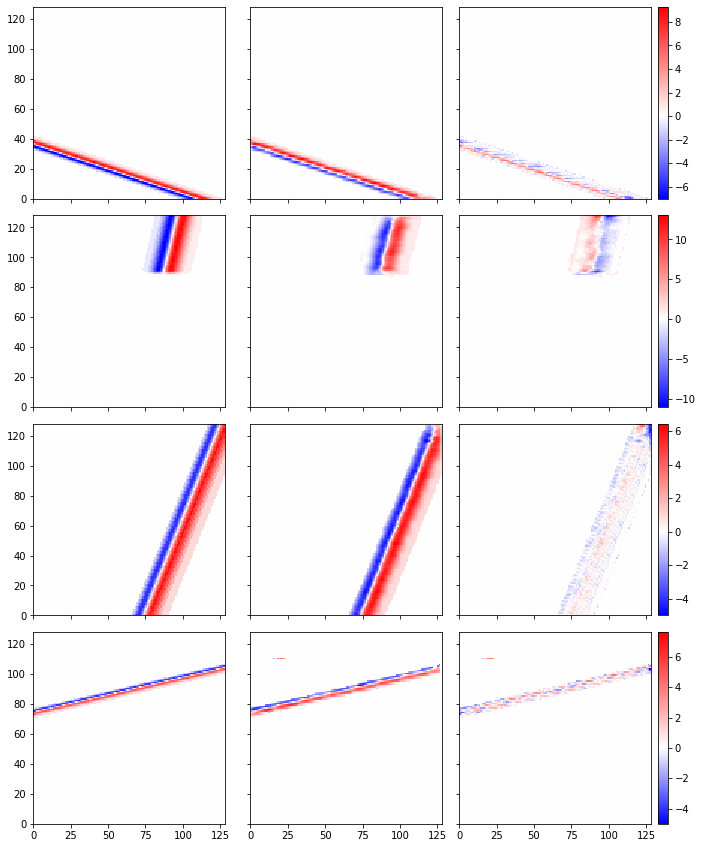

In [28]:
threshold = .5
X = next(iter(train_loader)).cuda()
X = X[:4]
with torch.no_grad():
    Y_c, Y_r = model(X)
    Y = Y_r * (Y_c > threshold)

num_samples = len(X)
width, ncols = 3.3, 3
fig, axes = plt.subplots(
    num_samples, ncols, 
    figsize=(width * ncols, width * num_samples * .9), 
    sharex=True, sharey=True)
cmap = 'bwr'

for x, y, ax_row in zip(X, Y, axes):
    x = x.squeeze().cpu().detach().numpy()
    y = y.squeeze().cpu().detach().numpy() 
    d = y - x

    vmin = min(x.min(), y.min(), d.min())
    vmax = max(x.max(), y.max(), d.max())
    divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0., vmax=vmax)

    ax = ax_row[0]
    ax.set_aspect(1)
    im = ax.pcolormesh(x, cmap=cmap, norm=divnorm)

    ax = ax_row[1]
    ax.set_aspect(1)
    im = ax.pcolormesh(y, cmap=cmap, norm=divnorm)

    ax = ax_row[2]
    ax.set_aspect(1)
    im = ax.pcolormesh(d, cmap=cmap, norm=divnorm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
plt.tight_layout()
plt.savefig(f'{path_prefix}/visualization_train.png', dpi=600, transparent=True)